# LoFi

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from typing import Callable
import matplotlib.pyplot as plt
from functools import partial
from jax.flatten_util import ravel_pytree

In [3]:
from rebayes import base
from rebayes.low_rank_filter import lofi
from rebayes.datasets import nonstat_1d_data as datagen

In [4]:
%config InlineBackend.figure_format = "retina"

## Dataset

In [5]:
key = jax.random.PRNGKey(314)
n_dist = 6
n_train = 100
data_flat, data_tasks = datagen.sample_1d_regression_sequence(key, n_dist, n_train=n_train)
jax.tree_map(jnp.shape, data_flat)

{'test': {'X': (600, 1), 'id_seq': (600,), 'y': (600, 1)},
 'train': {'X': (600, 1), 'id_seq': (600,), 'y': (600, 1)}}

In [6]:
X_train_seq = data_flat["train"]["X"]
Y_train_seq = data_flat["train"]["y"]
train_id_seq = data_flat["train"]["id_seq"]

X_test_seq = data_flat["test"]["X"]
Y_test_seq = data_flat["test"]["y"]
test_id_set = data_flat["test"]["id_seq"]


X_test_tasks = data_tasks["test"]["X"]
Y_test_tasks = data_tasks["test"]["y"]
X_train_tasks = data_tasks["train"]["X"]
Y_train_tasks = data_tasks["train"]["y"]

## Setup 

In [8]:
class MLP(nn.Module):
    n_out: int
    n_hidden: int
    activation: Callable = nn.tanh
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x

In [9]:
def callback(bel, pred_obs, t, Xt, Yt, bel_pred, apply_fn, **kwargs):    
    # eval on all tasks test set
    yhat = apply_fn(bel.mean, X_test_seq).squeeze()
    ytrue = Y_test_seq.squeeze()
    rmse_test_all_tasks = jnp.mean(jnp.square(yhat - ytrue)) 

    # eval on current task 
    task = train_id_seq[t]
    yhat = apply_fn(bel.mean, X_test_tasks[task]).squeeze()

    ytrue = Y_test_tasks[task].squeeze()
    rmse_test_current_task = jnp.sqrt(jnp.mean(jnp.square(yhat - ytrue)))
    mae_test_current_task = jnp.mean(jnp.abs(yhat - ytrue))

    out = {'rmse_test_all_tasks': rmse_test_all_tasks,
           'rmse_test_current_task': rmse_test_current_task,
           'mae_test_current_task': mae_test_current_task,
           'pred_test_current_task': yhat,
           "bel": bel,
           }
    
    return out

## Eval method

In [41]:
memory = 10

model = MLP(1, n_hidden=50)
agent, recfn = lofi.init_regression_agent(
    model=model,
    X_init=X_train_seq,
    dynamics_weights=1.0,
    dynamics_covariance=1e-7,
    emission_cov=0.05,
    memory_size=memory,
)


In [25]:
params_init = model.init(key, X_train_seq)
params_init, _ = ravel_pytree(params_init)

In [30]:
bel, outputs = agent.scan(
    initial_mean=params_init,
    initial_covariance=0.06,
    X=X_train_seq,
    Y=Y_train_seq,
    callback=partial(callback, apply_fn=agent.emission_mean_function),
    progress_bar=True,
)

bel = jax.block_until_ready(bel)

  0%|          | 0/600 [00:00<?, ?it/s]

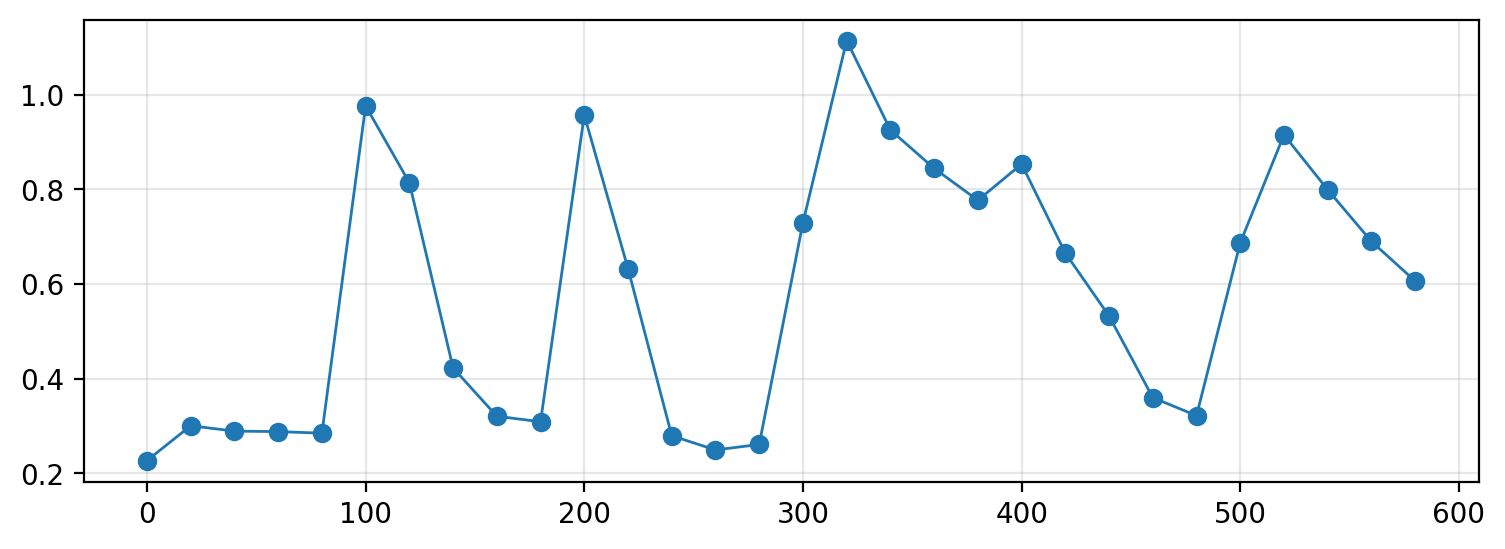

In [31]:
ksize = 20
kernel = jnp.ones(ksize) / ksize
hist_err = jnp.convolve(outputs["rmse_test_current_task"], kernel, mode="same")

ndata = len(hist_err)
ndx = jnp.arange(0, ndata, step=20)

plt.figure(figsize=(9, 3))
plt.plot(ndx, hist_err[ndx], marker="o", linewidth=1)
plt.grid(alpha=0.3)

## Comparisson posterior mean

In [38]:
def reshape_task(x):
    _, *shape = x.shape
    new_shape = (n_dist, -1, *shape)
    return x.reshape(new_shape)

@partial(jax.vmap, in_axes=(None, 0, None, None, None))
@partial(jax.vmap, in_axes=(None, 0, None, None, None))
def xsample(key, bel, agent, x, n_samples):
    yhat_samples = agent.pred_obs_mc(bel, key, x, n_samples)
    return yhat_samples

In [39]:
bel_reshape = jax.tree_map(reshape_task, outputs["bel"])
jax.tree_map(jnp.shape, bel_reshape)

key = jax.random.PRNGKey(3141)
n_samples = 55
xtest_ravel = jnp.linspace(-2.0, 2.0, num=100)[:, None]
yhat_xmap = xsample(key, bel_reshape, agent, xtest_ravel, n_samples).squeeze()
# tasks, num train, samples, x-eval
yhat_xmap.shape

(6, 100, 55, 100)

CPU times: user 756 ms, sys: 219 ms, total: 975 ms
Wall time: 516 ms


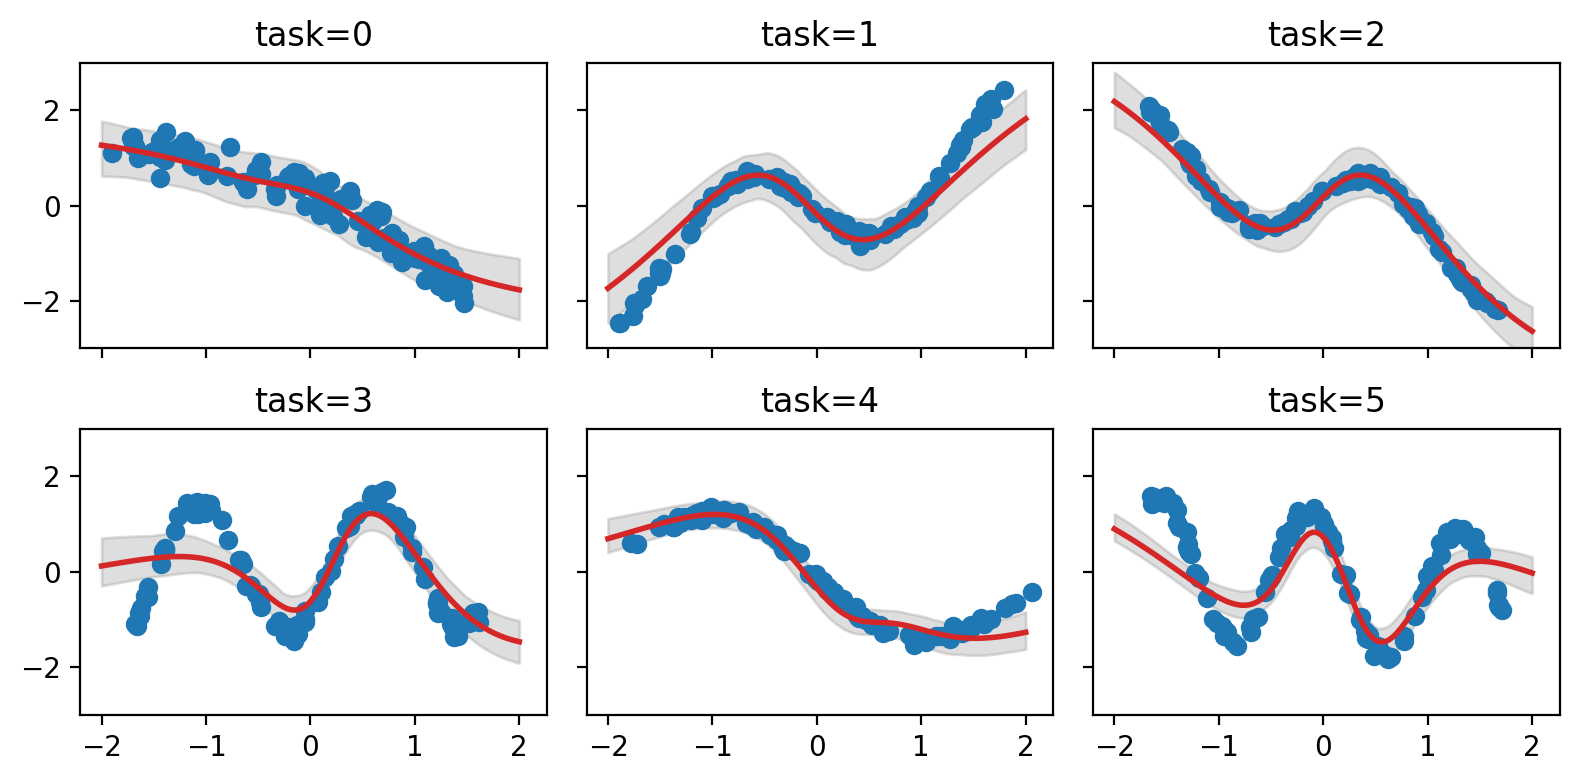

In [42]:
%%time
num_obs = 99
yhat_samples_all = yhat_xmap[:, num_obs, ...]

method = "lofi"
    
fig, axs = plt.subplots(2, 3, figsize=(8, 4), sharex=True, sharey=True)

for task, ax in enumerate(axs.ravel()):
    xtest = X_test_tasks[task][:num_obs]
    yhat_samples = yhat_samples_all[task]
    
    yhat_mean = yhat_samples.mean(axis=0)
    yhat_lb = jnp.quantile(yhat_samples, 0.05, axis=0)
    yhat_ub = jnp.quantile(yhat_samples, 0.95, axis=0)

    # for yhat in yhat_samples:
    #     ax.plot(xtest_ravel, yhat, c="tab:gray", linewidth=1, alpha=0.25)
    
    ax.fill_between(xtest_ravel.ravel(), yhat_lb, yhat_ub, color="tab:gray", alpha=0.25)
        
    ax.plot(xtest_ravel, yhat_mean, c="tab:red", linewidth=2)
    ax.scatter(X_train_tasks[task, :num_obs], Y_train_tasks[task, :num_obs])
    ax.set_title(f"{task=}")
    ax.set_ylim(-3, 3)
plt.tight_layout()